In [1]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import  BatchNormalization
from keras.layers.convolutional import *
from keras import regularizers ### for SVM
import numpy as np
import tensorflow as tf
# import theano
import  matplotlib.pyplot as plt
import matplotlib
import itertools
from numpy import*
from sklearn.utils import shuffle
%matplotlib inline
import random as rn
import os
os.environ['PYTHONASHSEED']= '0'
from keras.models import load_model

tf.reset_default_graph()

Using TensorFlow backend.


In [2]:
#setting  the  seed for nummy_gennerated random numbers
np.random.seed(7)
#seting the seed for python random numbers
rn.seed(124)
#seting the seed for tensorflow random numbers
tf.set_random_seed(57)

In [3]:
train_path = '.\MAKEUP\Train' 
valid_path = '.\MAKEUP\Valid' 
#test_path = '.\CASIA1\Test' 



In [4]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (224,224), classes = ['MakeUp','Normal'], batch_size =8)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size = (224,224), classes = ['MakeUp','Normal'], batch_size = 8)
# test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (224,224), classes = ['Au','Sp'], batch_size =8)

Found 604 images belonging to 2 classes.
Found 154 images belonging to 2 classes.


In [5]:
# plots images with labels  within jupyter notebook

def plots(ims, figsize = (12,6), rows=1, interp =False , titles = None):
    if  type(ims[0]) is  np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] !=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize) 
    cols = len(ims)// rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')
        plt.show()
        

In [6]:
imgs, labels = next(train_batches)


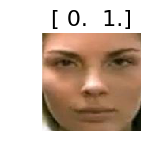

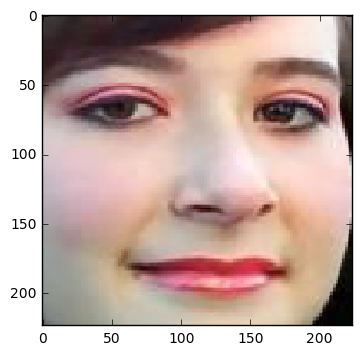

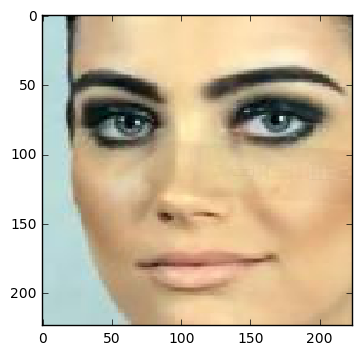

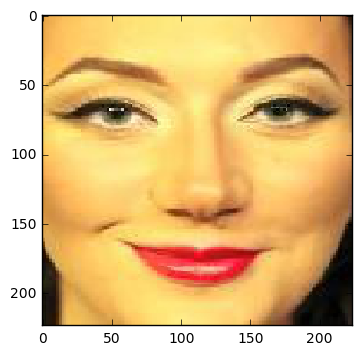

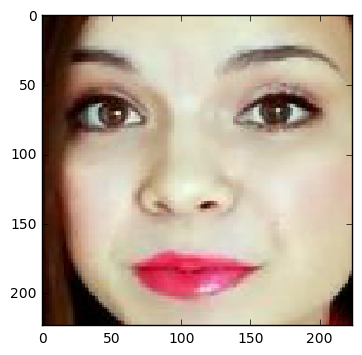

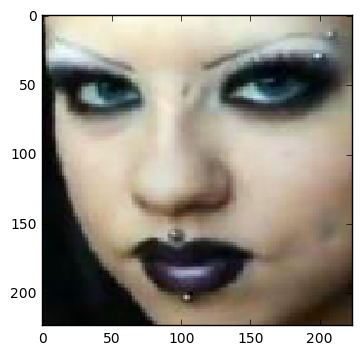

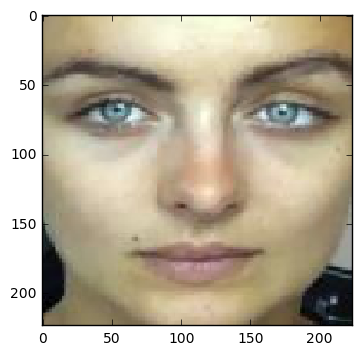

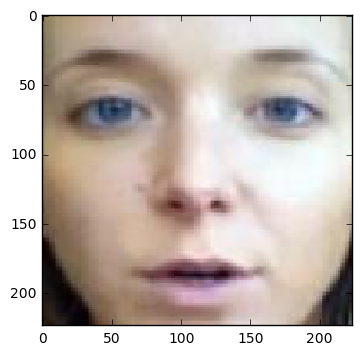

In [7]:
plots(imgs, titles = labels)

In [8]:
####  Build Fine-tuned  model
model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
print('Model loaded.')
model.summary()


Model loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________________

In [9]:
model.layers.pop()


In [10]:
last = model.layers[-1].output
x = Dense(2, activation = 'linear', kernel_regularizer=regularizers.l2(0.001))(last)
finetuned_model = Model(model.input, x)


In [11]:
n = len(finetuned_model.layers)
for idx, layer in enumerate(finetuned_model.layers):
    if idx < (n-2): 
           layer.trainable = False   
    else:
           layer.trainable = True   
          

In [12]:
opt = Adam(lr=0.001, decay=10e-6)
finetuned_model.compile(loss='hinge', optimizer=opt, metrics=['accuracy'])

# model.compile(loss='hinge', optimizer='adadelta', metrics=['accuracy'])

# sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='hinge', optimizer=sgd, metrics=['accuracy'])


In [13]:
from keras.callbacks import ModelCheckpoint
# Save check point
filepath = "weights.inception_resnet.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose =1, save_best_only = True, mode ='max')
callbacks_list= [checkpoint]
 # Fit the model
# model.fit(X,Y, validation_split=0.33, nb_epoch =150, batch_size =10, callbacks = callbacks_list, verbose =0)

history = finetuned_model.fit_generator(train_batches, steps_per_epoch = 120, validation_data = valid_batches, validation_steps=26, epochs =200, shuffle=True, callbacks = callbacks_list, verbose =2)

Epoch 1/200
 - 14s - loss: 0.5216 - acc: 0.4969 - val_loss: 0.5041 - val_acc: 0.5099

Epoch 00001: val_acc improved from -inf to 0.50990, saving model to weights.inception_resnet.best.hdf5
Epoch 2/200
 - 11s - loss: 0.5041 - acc: 0.4948 - val_loss: 0.5039 - val_acc: 0.5149

Epoch 00002: val_acc improved from 0.50990 to 0.51485, saving model to weights.inception_resnet.best.hdf5
Epoch 3/200
 - 11s - loss: 0.5038 - acc: 0.4958 - val_loss: 0.5036 - val_acc: 0.4851

Epoch 00003: val_acc did not improve
Epoch 4/200
 - 11s - loss: 0.5035 - acc: 0.4760 - val_loss: 0.5033 - val_acc: 0.5198

Epoch 00004: val_acc improved from 0.51485 to 0.51980, saving model to weights.inception_resnet.best.hdf5
Epoch 5/200
 - 11s - loss: 0.5033 - acc: 0.5063 - val_loss: 0.5030 - val_acc: 0.5149

Epoch 00005: val_acc did not improve
Epoch 6/200
 - 11s - loss: 0.5030 - acc: 0.5010 - val_loss: 0.5027 - val_acc: 0.5149

Epoch 00006: val_acc did not improve
Epoch 7/200
 - 11s - loss: 0.5026 - acc: 0.4885 - val_loss

dict_keys(['val_loss', 'acc', 'val_acc', 'loss'])


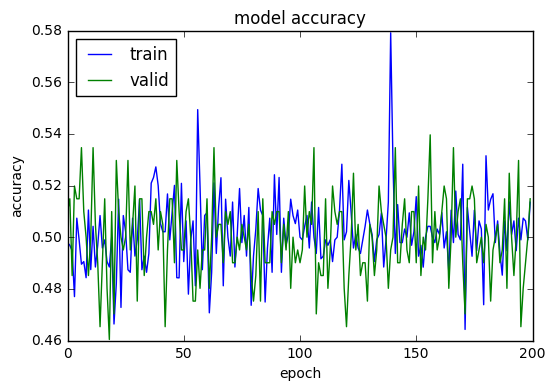

In [14]:

# plot history 
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc= 'upper left' )
plt.show()

In [15]:
# Save model 
#model.save('forgecy_image_model.h5')
# model.summary()
# model.get_weights()
# model.optimizer
## Load  model 
#from keras.models import load_model 
#model = load_model('forgecy_image_model.h5')


In [16]:
# # estimate accuracy on whole dataset using loaded weights
# scores = model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [17]:
test_imgs, test_labels = next(test_batches)
test_labels = test_labels[:, 0]
predictions = finetuned_model.predict_generator(test_batches, steps =1 , verbose = 0)
predictions
test_batches.class_indices
# rounded _predictions = model.predict_generator_classes(test_batches, steps =1 , verbose = 0)

NameError: name 'test_batches' is not defined

In [ ]:
cm = confusion_matrix(test_lables, np.round(predictions[:,0]))
cm_plot_labels = ['Au', 'Sp']
plot_confusion_matix(cm, cm_plot_labels, title = 'confusion Matrix')